In this notebook, we analyze the BACE enyzme and build machine learning models for predicting the Ki of ligands to the protein. We will use the `deepchem` library to load this data into memory, split into train/test/validation folds, build and cross-validate models, and report statistics.

In [1]:
%load_ext autoreload
%autoreload 2
%pdb off
import sys
# This will be removed
sys.path.append('/home/rbharath/deepchem/')
import deepchem
from deepchem.utils.save import load_from_disk

dataset_file= "../datasets/desc_canvas_aug30.csv"
dataset = load_from_disk(dataset_file)
num_display=10
pretty_columns = (
    "[" + ",".join(["'%s'" % column for column in dataset.columns.values[:num_display]])
    + ",...]")

crystal_dataset_file = "../datasets/crystal_desc_canvas_aug30.csv"
crystal_dataset = load_from_disk(crystal_dataset_file)

print("Columns of dataset: %s" % pretty_columns)
print("Number of examples in dataset: %s" % str(dataset.shape[0]))
print("Number of examples in crystal dataset: %s" % str(crystal_dataset.shape[0]))

Automatic pdb calling has been turned OFF
Columns of dataset: ['mol','CID','Class','Model','pIC50','MW','AlogP','HBA','HBD','RB',...]
Number of examples in dataset: 1522
Number of examples in crystal dataset: 25


To gain a visual understanding of compounds in our dataset, let's draw them using rdkit. We define a couple of helper functions to get started.

In [2]:
import tempfile
from rdkit import Chem
from rdkit.Chem import Draw
from itertools import islice
from IPython.display import Image, display, HTML

def display_images(filenames):
    """Helper to pretty-print images."""
    imagesList=''.join(
        ["<img style='width: 140px; margin: 0px; float: left; border: 1px solid black;' src='%s' />"
         % str(s) for s in sorted(filenames)])
    display(HTML(imagesList))    

def mols_to_pngs(mols, basename="test"):
    """Helper to write RDKit mols to png files."""
    filenames = []
    for i, mol in enumerate(mols):
        filename = "%s%d.png" % (basename, i)
        Draw.MolToFile(mol, filename)
        filenames.append(filename)
    return filenames

Now, we display a compound from the dataset. Note the complex ring structures and polar structures.

In [3]:
num_to_display = 12
molecules = []
for _, data in islice(dataset.iterrows(), num_to_display):
    molecules.append(Chem.MolFromSmiles(data["mol"]))
display_images(mols_to_pngs(molecules, basename="dataset"))

Now let's picture the compounds in the crystal structure collection

In [4]:
num_to_display = 12
molecules = []
for _, data in islice(crystal_dataset.iterrows(), num_to_display):
    molecules.append(Chem.MolFromSmiles(data["mol"]))
display_images(mols_to_pngs(molecules, basename="crystal_dataset"))

Analyzing the distribution of pIC50 values in the dataset gives us a nice spread.

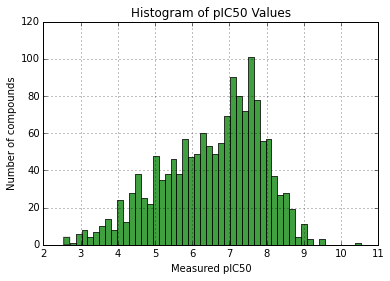

In [5]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

pIC50s = np.array(dataset["pIC50"])
# Remove some dirty data from the dataset
pIC50s = [pIC50 for pIC50 in pIC50s if pIC50 != '']
n, bins, patches = plt.hist(pIC50s, 50, facecolor='green', alpha=0.75)
plt.xlabel('Measured pIC50')
plt.ylabel('Number of compounds')
plt.title(r'Histogram of pIC50 Values')
plt.grid(True)
plt.show()

We now featurize the data using the Canvas samples. To do so, we must specify the columns in the data input that correspond to the features. (Note that CanvasUID is excluded!)

In [6]:
user_specified_features = ['MW','AlogP','HBA','HBD','RB','HeavyAtomCount','ChiralCenterCount','ChiralCenterCountAllPossible','RingCount','PSA','Estate','MR','Polar','sLi_Key','ssBe_Key','ssssBem_Key','sBH2_Key','ssBH_Key','sssB_Key','ssssBm_Key','sCH3_Key','dCH2_Key','ssCH2_Key','tCH_Key','dsCH_Key','aaCH_Key','sssCH_Key','ddC_Key','tsC_Key','dssC_Key','aasC_Key','aaaC_Key','ssssC_Key','sNH3_Key','sNH2_Key','ssNH2_Key','dNH_Key','ssNH_Key','aaNH_Key','tN_Key','sssNH_Key','dsN_Key','aaN_Key','sssN_Key','ddsN_Key','aasN_Key','ssssN_Key','daaN_Key','sOH_Key','dO_Key','ssO_Key','aaO_Key','aOm_Key','sOm_Key','sF_Key','sSiH3_Key','ssSiH2_Key','sssSiH_Key','ssssSi_Key','sPH2_Key','ssPH_Key','sssP_Key','dsssP_Key','ddsP_Key','sssssP_Key','sSH_Key','dS_Key','ssS_Key','aaS_Key','dssS_Key','ddssS_Key','ssssssS_Key','Sm_Key','sCl_Key','sGeH3_Key','ssGeH2_Key','sssGeH_Key','ssssGe_Key','sAsH2_Key','ssAsH_Key','sssAs_Key','dsssAs_Key','ddsAs_Key','sssssAs_Key','sSeH_Key','dSe_Key','ssSe_Key','aaSe_Key','dssSe_Key','ssssssSe_Key','ddssSe_Key','sBr_Key','sSnH3_Key','ssSnH2_Key','sssSnH_Key','ssssSn_Key','sI_Key','sPbH3_Key','ssPbH2_Key','sssPbH_Key','ssssPb_Key','sLi_Cnt','ssBe_Cnt','ssssBem_Cnt','sBH2_Cnt','ssBH_Cnt','sssB_Cnt','ssssBm_Cnt','sCH3_Cnt','dCH2_Cnt','ssCH2_Cnt','tCH_Cnt','dsCH_Cnt','aaCH_Cnt','sssCH_Cnt','ddC_Cnt','tsC_Cnt','dssC_Cnt','aasC_Cnt','aaaC_Cnt','ssssC_Cnt','sNH3_Cnt','sNH2_Cnt','ssNH2_Cnt','dNH_Cnt','ssNH_Cnt','aaNH_Cnt','tN_Cnt','sssNH_Cnt','dsN_Cnt','aaN_Cnt','sssN_Cnt','ddsN_Cnt','aasN_Cnt','ssssN_Cnt','daaN_Cnt','sOH_Cnt','dO_Cnt','ssO_Cnt','aaO_Cnt','aOm_Cnt','sOm_Cnt','sF_Cnt','sSiH3_Cnt','ssSiH2_Cnt','sssSiH_Cnt','ssssSi_Cnt','sPH2_Cnt','ssPH_Cnt','sssP_Cnt','dsssP_Cnt','ddsP_Cnt','sssssP_Cnt','sSH_Cnt','dS_Cnt','ssS_Cnt','aaS_Cnt','dssS_Cnt','ddssS_Cnt','ssssssS_Cnt','Sm_Cnt','sCl_Cnt','sGeH3_Cnt','ssGeH2_Cnt','sssGeH_Cnt','ssssGe_Cnt','sAsH2_Cnt','ssAsH_Cnt','sssAs_Cnt','dsssAs_Cnt','ddsAs_Cnt','sssssAs_Cnt','sSeH_Cnt','dSe_Cnt','ssSe_Cnt','aaSe_Cnt','dssSe_Cnt','ssssssSe_Cnt','ddssSe_Cnt','sBr_Cnt','sSnH3_Cnt','ssSnH2_Cnt','sssSnH_Cnt','ssssSn_Cnt','sI_Cnt','sPbH3_Cnt','ssPbH2_Cnt','sssPbH_Cnt','ssssPb_Cnt','sLi_Sum','ssBe_Sum','ssssBem_Sum','sBH2_Sum','ssBH_Sum','sssB_Sum','ssssBm_Sum','sCH3_Sum','dCH2_Sum','ssCH2_Sum','tCH_Sum','dsCH_Sum','aaCH_Sum','sssCH_Sum','ddC_Sum','tsC_Sum','dssC_Sum','aasC_Sum','aaaC_Sum','ssssC_Sum','sNH3_Sum','sNH2_Sum','ssNH2_Sum','dNH_Sum','ssNH_Sum','aaNH_Sum','tN_Sum','sssNH_Sum','dsN_Sum','aaN_Sum','sssN_Sum','ddsN_Sum','aasN_Sum','ssssN_Sum','daaN_Sum','sOH_Sum','dO_Sum','ssO_Sum','aaO_Sum','aOm_Sum','sOm_Sum','sF_Sum','sSiH3_Sum','ssSiH2_Sum','sssSiH_Sum','ssssSi_Sum','sPH2_Sum','ssPH_Sum','sssP_Sum','dsssP_Sum','ddsP_Sum','sssssP_Sum','sSH_Sum','dS_Sum','ssS_Sum','aaS_Sum','dssS_Sum','ddssS_Sum','ssssssS_Sum','Sm_Sum','sCl_Sum','sGeH3_Sum','ssGeH2_Sum','sssGeH_Sum','ssssGe_Sum','sAsH2_Sum','ssAsH_Sum','sssAs_Sum','dsssAs_Sum','ddsAs_Sum','sssssAs_Sum','sSeH_Sum','dSe_Sum','ssSe_Sum','aaSe_Sum','dssSe_Sum','ssssssSe_Sum','ddssSe_Sum','sBr_Sum','sSnH3_Sum','ssSnH2_Sum','sssSnH_Sum','ssssSn_Sum','sI_Sum','sPbH3_Sum','ssPbH2_Sum','sssPbH_Sum','ssssPb_Sum','sLi_Avg','ssBe_Avg','ssssBem_Avg','sBH2_Avg','ssBH_Avg','sssB_Avg','ssssBm_Avg','sCH3_Avg','dCH2_Avg','ssCH2_Avg','tCH_Avg','dsCH_Avg','aaCH_Avg','sssCH_Avg','ddC_Avg','tsC_Avg','dssC_Avg','aasC_Avg','aaaC_Avg','ssssC_Avg','sNH3_Avg','sNH2_Avg','ssNH2_Avg','dNH_Avg','ssNH_Avg','aaNH_Avg','tN_Avg','sssNH_Avg','dsN_Avg','aaN_Avg','sssN_Avg','ddsN_Avg','aasN_Avg','ssssN_Avg','daaN_Avg','sOH_Avg','dO_Avg','ssO_Avg','aaO_Avg','aOm_Avg','sOm_Avg','sF_Avg','sSiH3_Avg','ssSiH2_Avg','sssSiH_Avg','ssssSi_Avg','sPH2_Avg','ssPH_Avg','sssP_Avg','dsssP_Avg','ddsP_Avg','sssssP_Avg','sSH_Avg','dS_Avg','ssS_Avg','aaS_Avg','dssS_Avg','ddssS_Avg','ssssssS_Avg','Sm_Avg','sCl_Avg','sGeH3_Avg','ssGeH2_Avg','sssGeH_Avg','ssssGe_Avg','sAsH2_Avg','ssAsH_Avg','sssAs_Avg','dsssAs_Avg','ddsAs_Avg','sssssAs_Avg','sSeH_Avg','dSe_Avg','ssSe_Avg','aaSe_Avg','dssSe_Avg','ssssssSe_Avg','ddssSe_Avg','sBr_Avg','sSnH3_Avg','ssSnH2_Avg','sssSnH_Avg','ssssSn_Avg','sI_Avg','sPbH3_Avg','ssPbH2_Avg','sssPbH_Avg','ssssPb_Avg','First Zagreb (ZM1)','First Zagreb index by valence vertex degrees (ZM1V)','Second Zagreb (ZM2)','Second Zagreb index by valence vertex degrees (ZM2V)','Polarity (Pol)','Narumi Simple Topological (NST)','Narumi Harmonic Topological (NHT)','Narumi Geometric Topological (NGT)','Total structure connectivity (TSC)','Wiener (W)','Mean Wiener (MW)','Xu (Xu)','Quadratic (QIndex)','Radial centric (RC)','Mean Square Distance Balaban (MSDB)','Superpendentic (SP)','Harary (Har)','Log of product of row sums (LPRS)','Pogliani (Pog)','Schultz Molecular Topological (SMT)','Schultz Molecular Topological by valence vertex degrees (SMTV)','Mean Distance Degree Deviation (MDDD)','Ramification (Ram)','Gutman Molecular Topological (GMT)','Gutman MTI by valence vertex degrees (GMTV)','Average vertex distance degree (AVDD)','Unipolarity (UP)','Centralization (CENT)','Variation (VAR)','Molecular electrotopological variation (MEV)','Maximal electrotopological positive variation (MEPV)','Maximal electrotopological negative variation (MENV)','Eccentric connectivity (ECCc)','Eccentricity (ECC)','Average eccentricity (AECC)','Eccentric (DECC)','Valence connectivity index chi-0 (vX0)','Valence connectivity index chi-1 (vX1)','Valence connectivity index chi-2 (vX2)','Valence connectivity index chi-3 (vX3)','Valence connectivity index chi-4 (vX4)','Valence connectivity index chi-5 (vX5)','Average valence connectivity index chi-0 (AvX0)','Average valence connectivity index chi-1 (AvX1)','Average valence connectivity index chi-2 (AvX2)','Average valence connectivity index chi-3 (AvX3)','Average valence connectivity index chi-4 (AvX4)','Average valence connectivity index chi-5 (AvX5)','Quasi Wiener (QW)','First Mohar (FM)','Second Mohar (SM)','Spanning tree number (STN)','Kier benzene-likeliness index (KBLI)','Topological charge index of order 1 (TCI1)','Topological charge index of order 2 (TCI2)','Topological charge index of order 3 (TCI3)','Topological charge index of order 4 (TCI4)','Topological charge index of order 5 (TCI5)','Topological charge index of order 6 (TCI6)','Topological charge index of order 7 (TCI7)','Topological charge index of order 8 (TCI8)','Topological charge index of order 9 (TCI9)','Topological charge index of order 10 (TCI10)','Mean topological charge index of order 1 (MTCI1)','Mean topological charge index of order 2 (MTCI2)','Mean topological charge index of order 3 (MTCI3)','Mean topological charge index of order 4 (MTCI4)','Mean topological charge index of order 5 (MTCI5)','Mean topological charge index of order 6 (MTCI6)','Mean topological charge index of order 7 (MTCI7)','Mean topological charge index of order 8 (MTCI8)','Mean topological charge index of order 9 (MTCI9)','Mean topological charge index of order 10 (MTCI10)','Global topological charge (GTC)','Hyper-distance-path index (HDPI)','Reciprocal hyper-distance-path index (RHDPI)','Square reciprocal distance sum (SRDS)','Modified Randic connectivity (MRC)','Balaban centric (BC)','Lopping centric (LC)','Kier Hall electronegativity (KHE)','Sum of topological distances between N..N (STD(N N))','Sum of topological distances between N..O (STD(N O))','Sum of topological distances between N..S (STD(N S))','Sum of topological distances between N..P (STD(N P))','Sum of topological distances between N..F (STD(N F))','Sum of topological distances between N..Cl (STD(N Cl))','Sum of topological distances between N..Br (STD(N Br))','Sum of topological distances between N..I (STD(N I))','Sum of topological distances between O..O (STD(O O))','Sum of topological distances between O..S (STD(O S))','Sum of topological distances between O..P (STD(O P))','Sum of topological distances between O..F (STD(O F))','Sum of topological distances between O..Cl (STD(O Cl))','Sum of topological distances between O..Br (STD(O Br))','Sum of topological distances between O..I (STD(O I))','Sum of topological distances between S..S (STD(S S))','Sum of topological distances between S..P (STD(S P))','Sum of topological distances between S..F (STD(S F))','Sum of topological distances between S..Cl (STD(S Cl))','Sum of topological distances between S..Br (STD(S Br))','Sum of topological distances between S..I (STD(S I))','Sum of topological distances between P..P (STD(P P))','Sum of topological distances between P..F (STD(P F))','Sum of topological distances between P..Cl (STD(P Cl))','Sum of topological distances between P..Br (STD(P Br))','Sum of topological distances between P..I (STD(P I))','Sum of topological distances between F..F (STD(F F))','Sum of topological distances between F..Cl (STD(F Cl))','Sum of topological distances between F..Br (STD(F Br))','Sum of topological distances between F..I (STD(F I))','Sum of topological distances between Cl..Cl (STD(Cl Cl))','Sum of topological distances between Cl..Br (STD(Cl Br))','Sum of topological distances between Cl..I (STD(Cl I))','Sum of topological distances between Br..Br (STD(Br Br))','Sum of topological distances between Br..I (STD(Br I))','Sum of topological distances between I..I (STD(I I))','Wiener-type index from Z weighted distance matrix - Barysz matrix (WhetZ)','Wiener-type index from electronegativity weighted distance matrix (Whete)','Wiener-type index from mass weighted distance matrix (Whetm)','Wiener-type index from van der waals weighted distance matrix (Whetv)','Wiener-type index from polarizability weighted distance matrix (Whetp)','Balaban-type index from Z weighted distance matrix - Barysz matrix (JhetZ)','Balaban-type index from electronegativity weighted distance matrix (Jhete)','Balaban-type index from mass weighted distance matrix (Jhetm)','Balaban-type index from van der waals weighted distance matrix (Jhetv)','Balaban-type index from polarizability weighted distance matrix (Jhetp)','Topological diameter (TD)','Topological radius (TR)','Petitjean 2D shape (PJ2DS)','Balaban distance connectivity index (J)','Solvation connectivity index chi-0 (SCIX0)','Solvation connectivity index chi-1 (SCIX1)','Solvation connectivity index chi-2 (SCIX2)','Solvation connectivity index chi-3 (SCIX3)','Solvation connectivity index chi-4 (SCIX4)','Solvation connectivity index chi-5 (SCIX5)','Connectivity index chi-0 (CIX0)','Connectivity chi-1 [Randic connectivity] (CIX1)','Connectivity index chi-2 (CIX2)','Connectivity index chi-3 (CIX3)','Connectivity index chi-4 (CIX4)','Connectivity index chi-5 (CIX5)','Average connectivity index chi-0 (ACIX0)','Average connectivity index chi-1 (ACIX1)','Average connectivity index chi-2 (ACIX2)','Average connectivity index chi-3 (ACIX3)','Average connectivity index chi-4 (ACIX4)','Average connectivity index chi-5 (ACIX5)','reciprocal distance Randic-type index (RDR)','reciprocal distance square Randic-type index (RDSR)','1-path Kier alpha-modified shape index (KAMS1)','2-path Kier alpha-modified shape index (KAMS2)','3-path Kier alpha-modified shape index (KAMS3)','Kier flexibility (KF)','path/walk 2 - Randic shape index (RSIpw2)','path/walk 3 - Randic shape index (RSIpw3)','path/walk 4 - Randic shape index (RSIpw4)','path/walk 5 - Randic shape index (RSIpw5)','E-state topological parameter (ETP)','Ring Count 3 (RNGCNT3)','Ring Count 4 (RNGCNT4)','Ring Count 5 (RNGCNT5)','Ring Count 6 (RNGCNT6)','Ring Count 7 (RNGCNT7)','Ring Count 8 (RNGCNT8)','Ring Count 9 (RNGCNT9)','Ring Count 10 (RNGCNT10)','Ring Count 11 (RNGCNT11)','Ring Count 12 (RNGCNT12)','Ring Count 13 (RNGCNT13)','Ring Count 14 (RNGCNT14)','Ring Count 15 (RNGCNT15)','Ring Count 16 (RNGCNT16)','Ring Count 17 (RNGCNT17)','Ring Count 18 (RNGCNT18)','Ring Count 19 (RNGCNT19)','Ring Count 20 (RNGCNT20)','Atom Count (ATMCNT)','Bond Count (BNDCNT)','Atoms in Ring System (ATMRNGCNT)','Bonds in Ring System (BNDRNGCNT)','Cyclomatic number (CYCLONUM)','Number of ring systems (NRS)','Normalized number of ring systems (NNRS)','Ring Fusion degree (RFD)','Ring perimeter (RNGPERM)','Ring bridge count (RNGBDGE)','Molecule cyclized degree (MCD)','Ring Fusion density (RFDELTA)','Ring complexity index (RCI)','Van der Waals surface area (VSA)','MR1 (MR1)','MR2 (MR2)','MR3 (MR3)','MR4 (MR4)','MR5 (MR5)','MR6 (MR6)','MR7 (MR7)','MR8 (MR8)','ALOGP1 (ALOGP1)','ALOGP2 (ALOGP2)','ALOGP3 (ALOGP3)','ALOGP4 (ALOGP4)','ALOGP5 (ALOGP5)','ALOGP6 (ALOGP6)','ALOGP7 (ALOGP7)','ALOGP8 (ALOGP8)','ALOGP9 (ALOGP9)','ALOGP10 (ALOGP10)','PEOE1 (PEOE1)','PEOE2 (PEOE2)','PEOE3 (PEOE3)','PEOE4 (PEOE4)','PEOE5 (PEOE5)','PEOE6 (PEOE6)','PEOE7 (PEOE7)','PEOE8 (PEOE8)','PEOE9 (PEOE9)','PEOE10 (PEOE10)','PEOE11 (PEOE11)','PEOE12 (PEOE12)','PEOE13 (PEOE13)','PEOE14 (PEOE14)']

In [7]:
import tempfile, shutil
from deepchem.featurizers.featurize import DataFeaturizer

#Make directories to store the raw and featurized datasets.
feature_dir = tempfile.mkdtemp()
samples_dir = tempfile.mkdtemp()

crystal_feature_dir = tempfile.mkdtemp()
crystal_samples_dir = tempfile.mkdtemp()

featurizer = DataFeaturizer(tasks=["pIC50"],
                            smiles_field="mol",
                            id_field="CID",
                            user_specified_features=user_specified_features,
                            split_field="Model")
featurized_samples = featurizer.featurize(
    dataset_file, feature_dir, samples_dir, shard_size=2000)


crystal_featurized_samples = featurizer.featurize(
    crystal_dataset_file, crystal_feature_dir, crystal_samples_dir, shard_size=2000)

This data is already split into three subsets "Train" and "Test" with 20% and 80% respectively of the total data from the BACE enzyme. There is also a "Validation" set that contains data from a separate (but related assay). (Note that these names are really misnomers. The "Test" set would be called a validation set in standard machine-learning practice and the "Validation" set would typically be called an external test set.) Hence, we will rename the datasets after loading them.

In [8]:
splittype = "specified"
train_dir = tempfile.mkdtemp()
valid_dir = tempfile.mkdtemp()
test_dir = tempfile.mkdtemp()
crystal_dir = tempfile.mkdtemp()

train_samples, valid_samples, test_samples = featurized_samples.train_valid_test_split(
    splittype, train_dir, valid_dir, test_dir)
#NOTE THE RENAMING:
valid_samples, test_samples = test_samples, valid_samples

Let's quickly take a look at a compound in the validation set. (The compound displayed earlier was drawn from the train set).

In [9]:
valid_mols = [Chem.MolFromSmiles(str(compound["smiles"]))
              for compound in islice(valid_samples.itersamples(), num_to_display)]
display_images(mols_to_pngs(valid_mols, basename="valid_set"))

Let's now write these datasets to disk

In [10]:
from deepchem.utils.dataset import Dataset
train_dataset = Dataset(data_dir=train_dir, samples=train_samples, 
                        featurizers=[], tasks=["pIC50"],
                        use_user_specified_features=True)
valid_dataset = Dataset(data_dir=valid_dir, samples=valid_samples, 
                        featurizers=[], tasks=["pIC50"],
                        use_user_specified_features=True)
test_dataset = Dataset(data_dir=test_dir, samples=test_samples, 
                       featurizers=[], tasks=["pIC50"],
                       use_user_specified_features=True)
crystal_dataset = Dataset(data_dir=crystal_dir, samples=crystal_featurized_samples, 
                          featurizers=[], tasks=["pIC50"],
                          use_user_specified_features=True)
print("Number of compounds in train set")
print(len(train_dataset))
print("Number of compounds in validation set")
print(len(valid_dataset))
print("Number of compounds in test set")
print(len(test_dataset))
print("Number of compounds in crystal set")
print(len(crystal_dataset))

Number of compounds in train set
204
Number of compounds in validation set
1273
Number of compounds in test set
45
Number of compounds in crystal set
25


/home/rbharath/deepchem/deepchem/utils/dataset.py:229: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if features[ind] == "":


The performance of common machine-learning algorithms can be very sensitive to preprocessing of the data. One common transformation applied to data is to normalize it to have zero-mean and unit-standard-deviation. We will apply this transformation to the pIC50 values (as seen above, the pIC50s range from 2 to 11).

In [11]:
from deepchem.transformers import NormalizationTransformer
from deepchem.transformers import ClippingTransformer


input_transformers = [NormalizationTransformer(transform_X=True, dataset=train_dataset),
                      ClippingTransformer(transform_X=True, dataset=train_dataset)]
output_transformers = [NormalizationTransformer(transform_y=True, dataset=train_dataset)]
transformers = input_transformers + output_transformers
for transformer in transformers:
    transformer.transform(train_dataset)
for transformer in transformers:
    transformer.transform(valid_dataset)
for transformer in transformers:
    transformer.transform(test_dataset)
for transformer in transformers:
    transformer.transform(crystal_dataset)

We now fit simple random forest models to our datasets.

In [12]:
from deepchem.hyperparameters import HyperparamOpt
from sklearn.ensemble import RandomForestRegressor
from deepchem.models.standard import SklearnModel


def model_builder(task_types, params_dict, verbosity):
    n_estimators = params_dict["n_estimators"]
    max_features = params_dict["max_features"]
    return SklearnModel(
        task_types, params_dict,
        model_instance=RandomForestRegressor(n_estimators=n_estimators,
                                             max_features=max_features))
params_dict = {
    "n_estimators": [10, 100],
    "data_shape": [train_dataset.get_data_shape()],
    "max_features": ["auto", "sqrt", "log2", None],
    }
optimizer = HyperparamOpt(model_builder, {"pIC50": "regression"})
best_rf, best_rf_hyperparams, all_rf_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, output_transformers, metric="r2_score")

Model 0/8, Metric r2_score, Validation set 0: 0.186507
	best_validation_score so  far: -inf
Model 1/8, Metric r2_score, Validation set 1: 0.176354
	best_validation_score so  far: 0.186507
Model 2/8, Metric r2_score, Validation set 2: 0.201755
	best_validation_score so  far: 0.186507
Model 3/8, Metric r2_score, Validation set 3: 0.186934
	best_validation_score so  far: 0.201755
Model 4/8, Metric r2_score, Validation set 4: 0.229487
	best_validation_score so  far: 0.201755
Model 5/8, Metric r2_score, Validation set 5: 0.269268
	best_validation_score so  far: 0.229487
Model 6/8, Metric r2_score, Validation set 6: 0.278893
	best_validation_score so  far: 0.269268
Model 7/8, Metric r2_score, Validation set 7: 0.220223
	best_validation_score so  far: 0.278893
Best hyperparameters: [('n_estimators', 100), ('data_shape', (589,)), ('max_features', 'log2')]
train_score: 0.947125
validation_score: 0.278893


In [13]:
from deepchem.models.deep import SingleTaskDNN
import numpy.random

np.random.seed()
params_dict = {"activation": ["relu"],
                "momentum": [.9],
                "batch_size": [50],
                "init": ["glorot_uniform"],
                "data_shape": [train_dataset.get_data_shape()],
                "learning_rate": np.power(10., np.random.uniform(-5, -2, size=5)),
                "decay": np.power(10., np.random.uniform(-6, -4, size=5)),
                "nb_hidden": [1000],
                "nb_epoch": [40],
                "nesterov": [False],
                "dropout": [.5],
                "nb_layers": [1],
                "batchnorm": [False],
              }

optimizer = HyperparamOpt(SingleTaskDNN, {"pIC50": "regression"})
best_dnn, best_hyperparams, all_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, output_transformers, metric="r2_score", verbosity=None)

Using Theano backend.
ERROR (theano.sandbox.cuda): Failed to compile cuda_ndarray.cu: libcublas.so.7.0: cannot open shared object file: No such file or directory
ERROR:theano.sandbox.cuda:Failed to compile cuda_ndarray.cu: libcublas.so.7.0: cannot open shared object file: No such file or directory
WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: cuda unavilable)


Model 0/25, Metric r2_score, Validation set 0: 0.037620
	best_validation_score so  far: -inf
Model 1/25, Metric r2_score, Validation set 1: 0.121623
	best_validation_score so  far: 0.037620
Model 2/25, Metric r2_score, Validation set 2: 0.253740
	best_validation_score so  far: 0.121623
Model 3/25, Metric r2_score, Validation set 3: 0.260108
	best_validation_score so  far: 0.253740
Model 4/25, Metric r2_score, Validation set 4: 0.219395
	best_validation_score so  far: 0.260108
Model 5/25, Metric r2_score, Validation set 5: -0.256456
	best_validation_score so  far: 0.260108
Model 6/25, Metric r2_score, Validation set 6: 0.314359
	best_validation_score so  far: 0.260108
Model 7/25, Metric r2_score, Validation set 7: 0.211534
	best_validation_score so  far: 0.314359
Model 8/25, Metric r2_score, Validation set 8: 0.210707
	best_validation_score so  far: 0.314359
Model 9/25, Metric r2_score, Validation set 9: 0.193160
	best_validation_score so  far: 0.314359
Model 10/25, Metric r2_score, Val

Before evaluating the models, let's load the collection of datapoints drawn from crystal structures.

Now let's evaluate the best model on the validation and test sets and save the results to csv.

In [14]:
from deepchem.utils.evaluate import Evaluator

rf_train_csv_out = "rf_train_regressor.csv"
rf_train_stats_out = "rf_train_stats_regressor.txt"
rf_train_evaluator = Evaluator(best_rf, train_dataset, output_transformers)
rf_train_df, rf_train_r2score = rf_train_evaluator.compute_model_performance(
    rf_train_csv_out, rf_train_stats_out)
rf_train_r2_score = rf_train_r2score.iloc[0]["r2_score"]
print("RF Train set R^2 %f" % (rf_train_r2_score))

rf_valid_csv_out = "rf_valid_regressor.csv"
rf_valid_stats_out = "rf_valid_stats_regressor.txt"
rf_valid_evaluator = Evaluator(best_rf, valid_dataset, output_transformers)
rf_valid_df, rf_valid_r2score = rf_valid_evaluator.compute_model_performance(
    rf_valid_csv_out, rf_valid_stats_out)
rf_valid_r2_score = rf_valid_r2score.iloc[0]["r2_score"]
print("RF Valid set R^2 %f" % (rf_valid_r2_score))

rf_test_csv_out = "rf_test_regressor.csv"
rf_test_stats_out = "rf_test_stats_regressor.txt"
rf_test_evaluator = Evaluator(best_rf, test_dataset, output_transformers)
rf_test_df, rf_test_r2score = rf_test_evaluator.compute_model_performance(
    rf_test_csv_out, rf_test_stats_out)
rf_test_r2_score = rf_test_r2score.iloc[0]["r2_score"]
print("RF Test set R^2 %f" % (rf_test_r2_score))

rf_crystal_csv_out = "rf_crystal_regressor.csv"
rf_crystal_stats_out = "rf_crystal_stats_regressor.txt"
rf_crystal_evaluator = Evaluator(best_rf, crystal_dataset, output_transformers)
rf_crystal_df, rf_crystal_r2score = rf_crystal_evaluator.compute_model_performance(
    rf_crystal_csv_out, rf_crystal_stats_out)
rf_crystal_r2_score = rf_crystal_r2score.iloc[0]["r2_score"]
print("RF Crystal set R^2 %f" % (rf_crystal_r2_score))

RF Train set R^2 0.947125
RF Valid set R^2 0.278893
RF Test set R^2 0.469505
RF Crystal set R^2 0.000000


In [15]:
dnn_train_csv_out = "dnn_train_regressor.csv"
dnn_train_stats_out = "dnn_train_regressor_stats.txt"
dnn_train_evaluator = Evaluator(best_dnn, train_dataset, output_transformers)
dnn_train_df, dnn_train_r2score = dnn_train_evaluator.compute_model_performance(
    dnn_train_csv_out, dnn_train_stats_out)
dnn_train_r2_score = dnn_train_r2score.iloc[0]["r2_score"]
print("DNN Train set R^2 %f" % (dnn_train_r2_score))

dnn_valid_csv_out = "dnn_valid_regressor.csv"
dnn_valid_stats_out = "dnn_valid_regressor_stats.txt"
dnn_valid_evaluator = Evaluator(best_dnn, valid_dataset, output_transformers)
dnn_valid_df, dnn_valid_r2score = dnn_valid_evaluator.compute_model_performance(
    dnn_valid_csv_out, dnn_valid_stats_out)
dnn_valid_r2_score = dnn_valid_r2score.iloc[0]["r2_score"]
print("DNN Valid set R^2 %f" % (dnn_valid_r2_score))

dnn_test_csv_out = "dnn_test_regressor.csv"
dnn_test_stats_out = "dnn_test_regressor_stats.txt"
dnn_test_evaluator = Evaluator(best_dnn, test_dataset, output_transformers)
dnn_test_df, dnn_test_r2score = dnn_test_evaluator.compute_model_performance(
    dnn_test_csv_out, dnn_test_stats_out)
dnn_test_r2_score = dnn_test_r2score.iloc[0]["r2_score"]
print("DNN Test set R^2 %f" % (dnn_test_r2_score))

dnn_crystal_csv_out = "dnn_crystal_regressor.csv"
dnn_crystal_stats_out = "dnn_crystal_stats_regressor.txt"
dnn_crystal_evaluator = Evaluator(best_dnn, crystal_dataset, output_transformers)
dnn_crystal_df, dnn_crystal_r2score = dnn_crystal_evaluator.compute_model_performance(
    dnn_crystal_csv_out, dnn_crystal_stats_out)
dnn_crystal_r2_score = dnn_crystal_r2score.iloc[0]["r2_score"]
print("DNN Crystal set R^2 %f" % (dnn_crystal_r2_score))

DNN Train set R^2 0.625197
DNN Valid set R^2 0.322635
DNN Test set R^2 0.271734
DNN Crystal set R^2 0.000000


/home/rbharath/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


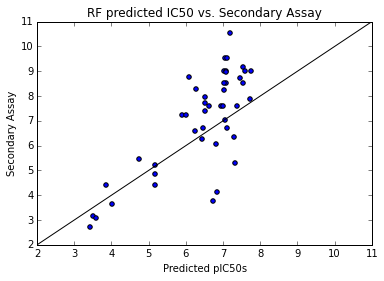

In [16]:
task = "pIC50"
rf_predicted_test = np.array(rf_test_df[task + "_pred"])
rf_true_test = np.array(rf_test_df[task])
plt.scatter(rf_predicted_test, rf_true_test)
plt.xlabel('Predicted pIC50s')
plt.ylabel('Secondary Assay')
plt.title(r'RF predicted IC50 vs. Secondary Assay')
plt.xlim([2, 11])
plt.ylim([2, 11])
plt.plot([2, 11], [2, 11], color='k')
plt.show()

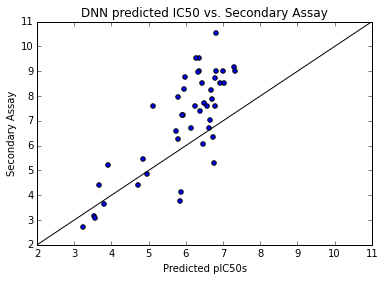

In [17]:
task = "pIC50"
dnn_predicted_test = np.array(dnn_test_df[task + "_pred"])
dnn_true_test = np.array(dnn_test_df[task])
plt.scatter(dnn_predicted_test, dnn_true_test)
plt.xlabel('Predicted pIC50s')
plt.ylabel('Secondary Assay')
plt.title(r'DNN predicted IC50 vs. Secondary Assay')
plt.xlim([2, 11])
plt.ylim([2, 11])
plt.plot([2, 11], [2, 11], color='k')
plt.show()

Now, we construct classification models for the data.

In [18]:
#Make directories to store the raw and featurized datasets.
c_feature_dir = tempfile.mkdtemp()
c_samples_dir = tempfile.mkdtemp()
c_crystal_feature_dir = tempfile.mkdtemp()
c_crystal_samples_dir = tempfile.mkdtemp()
c_train_dir = tempfile.mkdtemp()
c_valid_dir = tempfile.mkdtemp()
c_test_dir = tempfile.mkdtemp()
c_crystal_dir = tempfile.mkdtemp()

c_featurizer = DataFeaturizer(tasks=["Class"],
                            smiles_field="mol",
                            id_field="CID",
                            user_specified_features=user_specified_features,
                            split_field="Model")
c_featurized_samples = c_featurizer.featurize(
    dataset_file, c_feature_dir, c_samples_dir, shard_size=2000)
c_crystal_featurized_samples = c_featurizer.featurize(
    crystal_dataset_file, c_crystal_feature_dir, c_crystal_samples_dir, shard_size=2000)

In [19]:
c_train_samples, c_valid_samples, c_test_samples = c_featurized_samples.train_valid_test_split(
    splittype, c_train_dir, c_valid_dir, c_test_dir)
#NOTE THE RENAMING:
c_valid_samples, c_test_samples = c_test_samples, c_valid_samples

In [20]:
from deepchem.utils.dataset import Dataset
c_train_dataset = Dataset(data_dir=c_train_dir, samples=c_train_samples, 
                          featurizers=[], tasks=["Class"],
                          use_user_specified_features=True)
c_valid_dataset = Dataset(data_dir=c_valid_dir, samples=c_valid_samples, 
                          featurizers=[], tasks=["Class"],
                          use_user_specified_features=True)
c_test_dataset = Dataset(data_dir=c_test_dir, samples=c_test_samples, 
                         featurizers=[], tasks=["Class"],
                         use_user_specified_features=True)
c_crystal_dataset = Dataset(data_dir=c_crystal_dir, samples=c_crystal_featurized_samples, 
                            featurizers=[], tasks=["Class"],
                            use_user_specified_features=True)
print("Number of compounds in c_train set")
print(len(c_train_dataset))
print("Number of compounds in c_validation set")
print(len(c_valid_dataset))
print("Number of compounds in c_test set")
print(len(c_test_dataset))
print("Number of compounds in c_crystal set")
print(len(c_crystal_dataset))

Number of compounds in c_train set
204
Number of compounds in c_validation set
1273
Number of compounds in c_test set
45
Number of compounds in c_crystal set
25


In [21]:
from deepchem.transformers import NormalizationTransformer
from deepchem.transformers import ClippingTransformer


c_input_transformers = [NormalizationTransformer(transform_X=True, dataset=train_dataset),
                      ClippingTransformer(transform_X=True, dataset=train_dataset)]
c_output_transformers = []
c_transformers = c_input_transformers + c_output_transformers
for transformer in c_transformers:
    transformer.transform(c_train_dataset)
for transformer in c_transformers:
    transformer.transform(c_valid_dataset)
for transformer in c_transformers:
    transformer.transform(c_test_dataset)
for transformer in c_transformers:
    transformer.transform(c_crystal_dataset)

In [22]:
from deepchem.hyperparameters import HyperparamOpt
from sklearn.ensemble import RandomForestClassifier
from deepchem.models.standard import SklearnModel

def model_builder(task_types, params_dict, verbosity):
    n_estimators = params_dict["n_estimators"]
    max_features = params_dict["max_features"]
    return SklearnModel(
        task_types, params_dict,
        model_instance=RandomForestClassifier(n_estimators=n_estimators,
                                              max_features=max_features))
params_dict = {
    "n_estimators": [10, 100],
    "data_shape": [c_train_dataset.get_data_shape()],
    "max_features": ["auto", "sqrt", "log2", None],
    }
c_optimizer = HyperparamOpt(model_builder, {"Class": "classification"})
c_best_rf, c_best_rf_hyperparams, c_all_rf_results = c_optimizer.hyperparam_search(
    params_dict, c_train_dataset, c_valid_dataset, c_output_transformers, metric="roc_auc_score")

Model 0/8, Metric roc_auc_score, Validation set 0: 0.718956
	best_validation_score so  far: -inf
Model 1/8, Metric roc_auc_score, Validation set 1: 0.681130
	best_validation_score so  far: 0.718956
Model 2/8, Metric roc_auc_score, Validation set 2: 0.673560
	best_validation_score so  far: 0.718956
Model 3/8, Metric roc_auc_score, Validation set 3: 0.687243
	best_validation_score so  far: 0.718956
Model 4/8, Metric roc_auc_score, Validation set 4: 0.699159
	best_validation_score so  far: 0.718956
Model 5/8, Metric roc_auc_score, Validation set 5: 0.710670
	best_validation_score so  far: 0.718956
Model 6/8, Metric roc_auc_score, Validation set 6: 0.696389
	best_validation_score so  far: 0.718956
Model 7/8, Metric roc_auc_score, Validation set 7: 0.702598
	best_validation_score so  far: 0.718956
Best hyperparameters: [('n_estimators', 10), ('data_shape', (589,)), ('max_features', 'auto')]
train_score: 0.970588
validation_score: 0.718956


In [23]:
from deepchem.models.deep import SingleTaskDNN
import numpy.random

params_dict = {"activation": ["relu"],
                "momentum": [.9],
                "batch_size": [50],
                "init": ["glorot_uniform"],
                "data_shape": [train_dataset.get_data_shape()],
                "learning_rate": np.power(10., np.random.uniform(-5, -2, size=5)),
                "decay": np.power(10, np.random.uniform(-6, -4, size=5)),
                "nb_hidden": [1000],
                "nb_epoch": [40],
                "nesterov": [False],
                "dropout": [.5],
                "nb_layers": [1],
                "batchnorm": [False],
              }

c_optimizer = HyperparamOpt(SingleTaskDNN, {"Class": "classification"})
c_best_dnn, c_best_hyperparams, c_all_results = c_optimizer.hyperparam_search(
    params_dict, c_train_dataset, c_valid_dataset, c_output_transformers, metric="roc_auc_score")

Model 0/25, Metric roc_auc_score, Validation set 0: 0.714419
	best_validation_score so  far: -inf
Model 1/25, Metric roc_auc_score, Validation set 1: 0.675208
	best_validation_score so  far: 0.714419
Model 2/25, Metric roc_auc_score, Validation set 2: 0.500000
	best_validation_score so  far: 0.714419
Model 3/25, Metric roc_auc_score, Validation set 3: 0.595066
	best_validation_score so  far: 0.714419
Model 4/25, Metric roc_auc_score, Validation set 4: 0.619281
	best_validation_score so  far: 0.714419
Model 5/25, Metric roc_auc_score, Validation set 5: 0.710980
	best_validation_score so  far: 0.714419
Model 6/25, Metric roc_auc_score, Validation set 6: 0.684616
	best_validation_score so  far: 0.714419
Model 7/25, Metric roc_auc_score, Validation set 7: 0.500000
	best_validation_score so  far: 0.714419
Model 8/25, Metric roc_auc_score, Validation set 8: 0.609538
	best_validation_score so  far: 0.714419
Model 9/25, Metric roc_auc_score, Validation set 9: 0.651710
	best_validation_score so

In [24]:
c_rf_train_csv_out = "rf_train_classifier.csv"
c_rf_train_stats_out = "rf_train_stats_classifier.txt"
c_rf_train_evaluator = Evaluator(c_best_rf, c_train_dataset, c_output_transformers)
c_rf_train_df, c_rf_train_roc_auc_score = c_rf_train_evaluator.compute_model_performance(
    c_rf_train_csv_out, c_rf_train_stats_out)
c_rf_train_roc_auc_score = c_rf_train_roc_auc_score.iloc[0]["roc_auc_score"]
print("RF Train set ROC-AUC %f" % (c_rf_train_roc_auc_score))

c_rf_valid_csv_out = "rf_valid_classifier.csv"
c_rf_valid_stats_out = "rf_valid_stats_classifier.txt"
c_rf_valid_evaluator = Evaluator(c_best_rf, c_valid_dataset, c_output_transformers)
c_rf_valid_df, c_rf_valid_roc_auc_score = c_rf_valid_evaluator.compute_model_performance(
    c_rf_valid_csv_out, c_rf_valid_stats_out)
c_rf_valid_roc_auc_score = c_rf_valid_roc_auc_score.iloc[0]["roc_auc_score"]
print("RF Valid set ROC-AUC %f" % (c_rf_valid_roc_auc_score))

c_rf_test_csv_out = "rf_test_classifier.csv"
c_rf_test_stats_out = "rf_test_stats_classifier.txt"
c_rf_test_evaluator = Evaluator(c_best_rf, c_test_dataset, c_output_transformers)
c_rf_test_df, c_rf_test_roc_auc_score = c_rf_test_evaluator.compute_model_performance(
    c_rf_test_csv_out, c_rf_test_stats_out)
c_rf_test_roc_auc_score = c_rf_test_roc_auc_score.iloc[0]["roc_auc_score"]
print("RF Test set ROC-AUC %f" % (c_rf_test_roc_auc_score))

c_rf_crystal_csv_out = "rf_crystal_classifier.csv"
c_rf_crystal_stats_out = "rf_crystal_stats_classifier.txt"
c_rf_crystal_evaluator = Evaluator(c_best_rf, c_crystal_dataset, c_output_transformers)
c_rf_crystal_df, c_rf_crystal_roc_auc_score = c_rf_crystal_evaluator.compute_model_performance(
    c_rf_crystal_csv_out, c_rf_crystal_stats_out)
c_rf_crystal_roc_auc_score = c_rf_crystal_roc_auc_score.iloc[0]["roc_auc_score"]
print("RF Crystal set ROC-AUC %f" % (c_rf_crystal_roc_auc_score))

RF Train set ROC-AUC 0.970588
RF Valid set ROC-AUC 0.718956
RF Test set ROC-AUC 0.215909
RF Crystal set ROC-AUC 0.500000


/home/rbharath/deepchem/deepchem/utils/evaluate.py:42: UserWarning: ROC AUC score calculation failed.
  warnings.warn("ROC AUC score calculation failed.")


In [25]:
c_dnn_train_csv_out = "c_dnn_train_classifier.csv"
c_dnn_train_stats_out = "c_dnn_train_stats_classifier.txt"                                   
c_dnn_train_evaluator = Evaluator(c_best_dnn, c_train_dataset, c_output_transformers)            
c_dnn_train_df, c_dnn_train_roc_auc_score = c_dnn_train_evaluator.compute_model_performance(
    c_dnn_train_csv_out, c_dnn_train_stats_out)
c_dnn_train_roc_auc_score = c_dnn_train_roc_auc_score.iloc[0]["roc_auc_score"]               
print("DNN Train set ROC-AUC %f" % (c_dnn_train_roc_auc_score))

c_dnn_valid_csv_out = "c_dnn_valid_classifier.csv"                                           
c_dnn_valid_stats_out = "c_dnn_valid_stats_classifier.txt"                                   
c_dnn_valid_evaluator = Evaluator(c_best_dnn, c_valid_dataset, c_output_transformers)            
c_dnn_valid_df, c_dnn_valid_roc_auc_score = c_dnn_valid_evaluator.compute_model_performance(
    c_dnn_valid_csv_out, c_dnn_valid_stats_out)
c_dnn_valid_roc_auc_score = c_dnn_valid_roc_auc_score.iloc[0]["roc_auc_score"]               
print("DNN Valid set ROC-AUC %f" % (c_dnn_valid_roc_auc_score))
                                                                                             
c_dnn_test_csv_out = "c_dnn_test_classifier.csv"
c_dnn_test_stats_out = "c_dnn_test_stats_classifier.txt"                                                                                                                                
c_dnn_test_evaluator = Evaluator(c_best_dnn, c_test_dataset, c_output_transformers)                                                                                                         
c_dnn_test_df, c_dnn_test_roc_auc_score = c_dnn_test_evaluator.compute_model_performance(                                                                                          
    c_dnn_test_csv_out, c_dnn_test_stats_out)
c_dnn_test_roc_auc_score = c_dnn_test_roc_auc_score.iloc[0]["roc_auc_score"]                                                                                                            
print("DNN Test set ROC-AUC %f" % (c_dnn_test_roc_auc_score))

c_dnn_crystal_csv_out = "c_dnn_crystal_classifier.csv"
c_dnn_crystal_stats_out = "c_dnn_crystal_stats_classifier.txt"                                                                                                                          
c_dnn_crystal_evaluator = Evaluator(c_best_dnn, c_crystal_dataset, c_output_transformers)                                                                                                   
c_dnn_crystal_df, c_dnn_crystal_roc_auc_score = c_dnn_crystal_evaluator.compute_model_performance(
    c_dnn_crystal_csv_out, c_dnn_crystal_stats_out)
c_dnn_crystal_roc_auc_score = c_dnn_crystal_roc_auc_score.iloc[0]["roc_auc_score"]                                                                                                      
print("DNN Crystal set ROC-AUC %f" % (c_dnn_crystal_roc_auc_score))


DNN Train set ROC-AUC 0.882353
DNN Valid set ROC-AUC 0.716974
DNN Test set ROC-AUC 0.215909
DNN Crystal set ROC-AUC 0.500000


We notice that the trained DNN classifier doesn't generalize well. The DNN requires the regression values to learn meaningful models. Thus, we use the trained DNN regressor and threshold to obtain classification results

In [26]:
threshold = 7.

dnn_train_csv_out = "dnn_train_classifier.csv"    
dnn_train_stats_out = "dnn_train_stats_classifier.txt"                                       
dnn_train_evaluator = Evaluator(best_dnn, c_train_dataset, output_transformers)
dnn_train_df, dnn_train_roc_auc_score = dnn_train_evaluator.compute_model_performance(      
    dnn_train_csv_out, dnn_train_stats_out, threshold=threshold)
dnn_train_roc_auc_score = dnn_train_roc_auc_score.iloc[0]["roc_auc_score"]                   
print("DNN Train set ROC-AUC %f" % (dnn_train_roc_auc_score))

dnn_valid_csv_out = "dnn_valid_classifier.csv"                                               
dnn_valid_stats_out = "dnn_valid_stats_classifier.txt"                                       
dnn_valid_evaluator = Evaluator(best_dnn, c_valid_dataset, output_transformers)                
dnn_valid_df, dnn_valid_roc_auc_score = dnn_valid_evaluator.compute_model_performance(      
    dnn_valid_csv_out, dnn_valid_stats_out, threshold=threshold)
dnn_valid_roc_auc_score = dnn_valid_roc_auc_score.iloc[0]["roc_auc_score"]                   
print("DNN Valid set ROC-AUC %f" % (dnn_valid_roc_auc_score))
                                                                                             
dnn_test_csv_out = "dnn_test_classifier.csv"
dnn_test_stats_out = "dnn_test_stats_classifier.txt"                                                                                                                                    
dnn_test_evaluator = Evaluator(best_dnn, c_test_dataset, output_transformers)                                                                                                             
dnn_test_df, dnn_test_roc_auc_score = dnn_test_evaluator.compute_model_performance(                                                                                                
    dnn_test_csv_out, dnn_test_stats_out, threshold=threshold)
dnn_test_roc_auc_score = dnn_test_roc_auc_score.iloc[0]["roc_auc_score"]                                                                                                                
print("DNN Test set ROC-AUC %f" % (dnn_test_roc_auc_score))

dnn_crystal_csv_out = "dnn_crystal_classifier.csv"
dnn_crystal_stats_out = "dnn_crystal_stats_classifier.txt"                                                                                                                              
dnn_crystal_evaluator = Evaluator(best_dnn, c_crystal_dataset, output_transformers)                                                                                                       
dnn_crystal_df, dnn_crystal_roc_auc_score = dnn_crystal_evaluator.compute_model_performance(
    dnn_crystal_csv_out, dnn_crystal_stats_out, threshold=threshold)
dnn_crystal_roc_auc_score = dnn_crystal_roc_auc_score.iloc[0]["roc_auc_score"]                                                                                                          
print("DNN Crystal set ROC-AUC %f" % (dnn_crystal_roc_auc_score))

DNN Train set ROC-AUC 0.632353
DNN Valid set ROC-AUC 0.634492
DNN Test set ROC-AUC 0.545455
DNN Crystal set ROC-AUC 0.500000
